In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

import os
import multiprocessing as mp
from tqdm import tqdm
# import time

# For Perceptron
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder


### Data Preprocessing

In [2]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (64, 64))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))


# Ref.: https://github.com/Ixiaohuihuihui/Extract-color-histogram-feature/blob/master/rgb_feature.py
# extract rgb features
def ExtractColorHistFeatures(image):
    features = []
    for channel in range(3):
        hist = cv2.calcHist(images=[image], channels=[channel], mask=None, histSize=[64], ranges=[0,256])
        hist = cv2.normalize(hist, hist)
        # features.extend(hist)
        features.append(hist)
    return features

with mp.Pool(processes=NUM_PROCESSES) as pool:
    ### tqdm returns an iterator
    # train_features = pool.map(ExtractFeatures, tqdm(resized_train_imgs))
    # val_features = pool.map(ExtractFeatures, tqdm(resized_val_imgs))
    # test_features = pool.map(ExtractFeatures, tqdm(resized_test_imgs))
    train_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_train_imgs), total=len(resized_train_imgs)))
    val_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_val_imgs), total=len(resized_val_imgs)))
    test_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_test_imgs), total=len(resized_test_imgs)))


# flatten and reshape the features into (n_samples, n_features)
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

def FlattenFeatures(feature):
    return feature.flatten()

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = np.array(pool.map(FlattenFeatures, tqdm(train_features)))
    val_features = np.array(pool.map(FlattenFeatures, tqdm(val_features)))
    test_features = np.array(pool.map(FlattenFeatures, tqdm(test_features)))

# # flatten and reshape the features into (n_samples, n_features)
# resized_train_imgs = np.array(resized_train_imgs)
# resized_val_imgs = np.array(resized_val_imgs)
# resized_test_imgs = np.array(resized_test_imgs)

# def FlattenImages(image):
#     return image.flatten()

# with mp.Pool(processes=NUM_PROCESSES) as pool:
#     resized_train_imgs = np.array(pool.map(FlattenImages, tqdm(resized_train_imgs)))
#     resized_val_imgs = np.array(pool.map(FlattenImages, tqdm(resized_val_imgs)))
#     resized_test_imgs = np.array(pool.map(FlattenImages, tqdm(resized_test_imgs)))

100%|██████████| 450/450 [00:00<00:00, 23480.25it/s]


In [3]:
def onehot(label, n_classes):
    enc = np.zeros(shape=(len(label), n_classes))
    for idx, val in enumerate(label):
        enc[idx, val] = 1
    return enc

train_label = onehot(np.array(train_label), 50)
val_label = onehot(np.array(val_label), 50)
test_label = onehot(np.array(test_label), 50)

In [7]:
class DataLoader:
    def __init__(self, data, labels, batch_size=32, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = data.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.indices = np.arange(self.num_samples)
        self.current_batch = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            self.current_batch = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
            
        batch_indices = self.indices[self.current_batch*self.batch_size : (self.current_batch+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        self.current_batch += 1
        
        return batch_data, batch_labels
    


train_dataloader = DataLoader(train_features, train_label, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_features, val_label, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_features, test_label, batch_size=64, shuffle=True)

### Two Layer Perceptron

In [27]:
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size  # input layer size
        self.hidden_size = hidden_size  # hidden layer size
        self.output_size = output_size  # output layer size (# of classes)
        
        # weight initialization
        np.random.seed(42)
        self.limit = 1 / math.sqrt(input_size)
        # self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.weights1 = np.random.uniform(low=-self.limit, high=self.limit, size=(self.input_size, self.hidden_size))
        self.biases1 = np.zeros((1, self.hidden_size))
        # self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        self.weights2 = np.random.uniform(low=-self.limit, high=self.limit, size=(self.hidden_size, self.output_size))
        self.biases2 = np.zeros((1, self.output_size))
        
    def forward(self, X):
        # Layer 1
        self.z1 = np.dot(X, self.weights1) + self.biases1
        # self.a1 = np.exp(self.z1) / np.sum(np.exp(self.z1), axis=1, keepdims=True)  # Softmax
        self.a1 = 1 / (1 + np.exp(-self.z1))  # Sigmoid
        # self.a1 = np.maximum(np.zeros(self.z1.shape), self.z1)  # ReLU
        self.a1 = np.arcsinh(self.z1) / 5 + 0.5  # another activation by Yang, arcsinh(x) = np.log(x + np.sqrt(x^2 + 1))
        
        # Layer 2
        self.z2 = np.dot(self.a1, self.weights2) + self.biases2
        self.a2 = np.exp(self.z2) / np.sum(np.exp(self.z2), axis=1, keepdims=True)
        
        return self.a2
    
    def backward(self, X, y, learning_rate):
        # Compute error
        delta3 = self.a2 - y  # layer 2 to layer 3
        # delta2 = np.dot(delta3, self.weights2.T) * (self.a1 * (1 - self.a1))
        delta2 = np.dot(delta3, self.weights2.T) * (1 / 5 * np.sqrt(self.a1**2 + 1))  # layer 1 to layer 2
        
        # Compute gradients
        d_weights2 = np.dot(self.a1.T, delta3)
        d_biases2 = np.sum(delta3, axis=0, keepdims=True)
        d_weights1 = np.dot(X.T, delta2)
        d_biases1 = np.sum(delta2, axis=0)
        
        # Update weights and biases
        self.weights2 -= learning_rate * d_weights2
        self.biases2 -= learning_rate * d_biases2
        self.weights1 -= learning_rate * d_weights1
        self.biases1 -= learning_rate * d_biases1
        
    def train(self, train_dataloader, val_dataloader, learning_rate, epochs):
        train_losses = []
        val_losses = []
        train_accuracy = []
        val_accuracy = []
        for epoch in range(epochs):
            # Train
            loss_epoch, acc_epoch = 0, 0
            for X, y in train_dataloader:
                # Forward pass
                output = self.forward(X)
                
                # Compute loss
                loss = np.mean(-np.sum(y * np.log(output), axis=1))
                
                # Compute accuracy
                acc = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))

                # Backward pass
                self.backward(X, y, learning_rate)

                loss_epoch += loss
                acc_epoch += acc
            
            loss_epoch /= train_dataloader.num_batches
            acc_epoch /= train_dataloader.num_batches
            train_losses.append(loss_epoch)
            train_accuracy.append(acc_epoch)
            
            # # Print progress
            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch + 1}, Train Loss {loss_epoch:.4f}")
    
            # Validation
            loss_epoch, acc_epoch = 0, 0
            for X, y in val_dataloader:
                # Forward pass
                output = self.forward(X)

                # Compute loss
                loss = np.mean(-np.sum(y * np.log(output), axis=1))

                # Compute accuracy
                acc = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))

                loss_epoch += loss
                acc_epoch += acc
            
            loss_epoch /= val_dataloader.num_batches
            acc_epoch /= val_dataloader.num_batches
            val_losses.append(loss_epoch)
            val_accuracy.append(acc_epoch)

            # Print progress
            if epoch % 1 == 0:
                print(f"Epoch: {epoch+1}, Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_losses[epoch]:.4f}")

        return train_losses, val_losses, train_accuracy, val_accuracy


    def predict(self, X):
        # Forward pass
        output = self.forward(X)
        
        # Return predicted class
        return np.argmax(output, axis=1)


### Training & Evaluation

In [28]:
perceptron = TwoLayerPerceptron(input_size=train_features.shape[1],
                                hidden_size=32,
                                output_size=50)

# Train model
train_losses, val_losses, train_accuracy, val_accuracy = perceptron.train(train_dataloader=train_dataloader,
                                                                          val_dataloader=val_dataloader,
                                                                          learning_rate=1e-2,
                                                                          epochs=30)

Epoch: 1, Train Loss: 3.9224, Val Loss: 3.8841
Epoch: 2, Train Loss: 3.8670, Val Loss: 3.8440
Epoch: 3, Train Loss: 3.8086, Val Loss: 3.8346
Epoch: 4, Train Loss: 3.7611, Val Loss: 3.7489
Epoch: 5, Train Loss: 3.7240, Val Loss: 3.7755
Epoch: 6, Train Loss: 3.7025, Val Loss: 3.8149
Epoch: 7, Train Loss: 3.6877, Val Loss: 3.6845
Epoch: 8, Train Loss: 3.6754, Val Loss: 3.7211
Epoch: 9, Train Loss: 3.6650, Val Loss: 3.6510
Epoch: 10, Train Loss: 3.6557, Val Loss: 3.6338
Epoch: 11, Train Loss: 3.6476, Val Loss: 3.6274
Epoch: 12, Train Loss: 3.6403, Val Loss: 3.6416
Epoch: 13, Train Loss: 3.6353, Val Loss: 3.6236
Epoch: 14, Train Loss: 3.6306, Val Loss: 3.5945
Epoch: 15, Train Loss: 3.6274, Val Loss: 3.5816
Epoch: 16, Train Loss: 3.6247, Val Loss: 3.7749
Epoch: 17, Train Loss: 3.6226, Val Loss: 3.6619
Epoch: 18, Train Loss: 3.6214, Val Loss: 3.5586
Epoch: 19, Train Loss: 3.6195, Val Loss: 3.5824
Epoch: 20, Train Loss: 3.6176, Val Loss: 3.6642
Epoch: 21, Train Loss: 3.6164, Val Loss: 3.6342
E

In [29]:
# Evaluate model
y_pred = perceptron.predict(train_features)
accuracy = np.mean(y_pred == np.argmax(train_label, axis=1))
print(f"Train Accuracy: {accuracy:.4f}")

# Evaluate model
y_pred = perceptron.predict(val_features)
accuracy = np.mean(y_pred == np.argmax(val_label, axis=1))
print(f"Validation Accuracy: {accuracy:.4f}")

# Evaluate model
y_pred = perceptron.predict(test_features)
accuracy = np.mean(y_pred == np.argmax(test_label, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

Train Accuracy: 0.0889
Validation Accuracy: 0.0978
Test Accuracy: 0.0711


In [34]:
EPOCHS = 30

def draw_losses(train_losses=None, val_losses=None, test_losses=None):
    if train_losses!=None:
        plt.plot(np.arange(EPOCHS), train_losses, label='Training Loss')
    if val_losses!=None:
        plt.plot(np.arange(EPOCHS), val_losses, label='Validation Loss')
    if test_losses!=None:    
        plt.plot(np.arange(EPOCHS), test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./pic/TwoLayerPerceptron_loss.png')
    plt.show()


def draw_accuracy(train_acc=None, val_acc=None, test_acc=None):
    if train_acc!=None:
        plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
    if val_acc!=None:
        plt.plot(np.arange(EPOCHS), val_acc, label='Validation Accuracy')
    if test_acc!=None:    
        plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./pic/TwoLayerPerceptron_acc.png')
    plt.show()

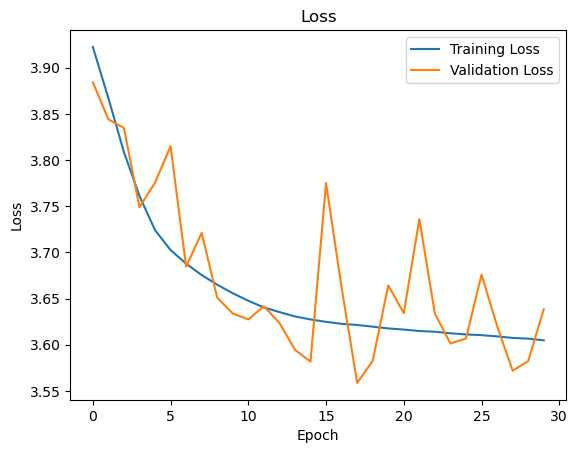

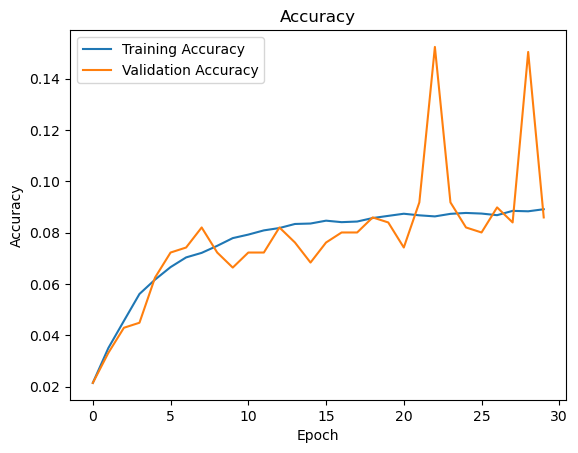

In [35]:
draw_losses(train_losses=train_losses, val_losses=val_losses)
draw_accuracy(train_acc=train_accuracy, val_acc=val_accuracy)